# Obtention des données

On a obtenu les données de Strava en utilisant la technique décrite sur http://scottpdawson.com/export-strava-workout-data/, incluant un petit bash script pour automatiser les choses:

```
#!/bin/bash
for number in {1..36}
do
curl "https://www.strava.com/athlete/training_activities?keywords=&activity_type=&workout_type=&commute=&private_activities=&trainer=&gear=&new_activity_only=false&page=${number}&per_page=20" -H '....' -H 'Accept-Encoding: gzip, deflate, br' -H 'X-CSRF-Token: WWSf3DMb4Fwfu8jCpxBtaXR1PkViY12vtvm8L38zlxY=' -H 'Accept-Language: fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4,es;q=0.2' -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36' -H 'Accept: text/javascript, application/javascript, application/ecmascript, application/x-ecmascript' -H 'Referer: https://www.strava.com/athlete/training' -H 'X-Requested-With: XMLHttpRequest' -H 'Connection: keep-alive' --compressed > res_$number.json
done
exit 0
```

Ce sera a refaire car res_17 etait corrompue.


Ensuite, pour regrouper les fichiers ensemble, on va faire...

In [137]:
import glob, os
import json
files = glob.glob("res_*.json")
activities = []
for file in files:
    act = json.loads(open(file, 'r').read())
    activities += act['models']
print len(activities)

699


# Nettoyage et préparation des données

Ensuite, on veut créer des fichiers de features et de resultats pour les envoyer dans un modèle d'apprentissage. On veut que les entrées soient un tableau ou chaque ligne est une activité, et les colonnes sont:

- coordonnée du point de départ
- date (mois/jour)
- elapsed_time_raw (secondes)
- moving_time_raw (secondes)
- distace_raw  (metres)
- elevation_gain (metres)
- has_latlng (booleen) pour distinguer les spinnings

Et les catégories en sortie seront obtenues par un mix de:

- type (Ride)
- display_type
- activity_type_display_name
- peut-être "name"

Pour s'aider à crééer les catégories, je voudrais connaître tous les types possibles:

In [138]:
print "Types: " + str(set([activity['type'] for activity in activities]))
print "Display types: " + str(set([activity['display_type'] for activity in activities]))
print "activity types display ames: " + str(set([activity['activity_type_display_name'] for activity in activities]))

Types: set([u'Run', u'Crossfit', u'Ride', u'Walk', u'Snowshoe', u'BackcountrySki', u'VirtualRide', u'Workout', u'NordicSki'])
Display types: set([u'Marche', u'Crossfit', u'Raquettes', u'Ski nordique', u'Course', u'Sortie \xe0 v\xe9lo', u'Entra\xeenement', u'Ski de randonn\xe9e', u'Sortie \xe0 v\xe9lo virtuelle'])
activity types display ames: set([u'Marche', u'Raquettes', u'Course \xe0 pied', u'Ski nordique', u'Sortie \xe0 v\xe9lo', u'Entra\xeenement', u'Ski de randonn\xe9e', u'Sortie \xe0 v\xe9lo virtuelle'])


Je vais utiliser les types. J'aurais aimé pouvoir distinguer le vélo de route du vélo de montagne, mais ce n'est pas possible. Les seules nuances sont que NordicSki et BackcountrySky devraient être les mêmes; Workout et Crossfit aussi. Aussi, les "spinnings" sont des "Rides", ça ne peut pas tenir la route, il faut en faire un type différent... Et je ne comprends pas pourquoi j'ai des "Walks": je ne consigne pas mes marches dans Strava. Ce doit plutôt être des "Run".

Ça peut se corriger...


In [139]:
for activity in activities:
    if activity['type'] == 'NordicSki':
        activity['type'] = 'BackcountrySki'
    if activity['type'] == 'Workout':
        activity['type'] = 'Crossfit'
    if activity['type'] == 'Ride' and 'spinning' in activity['name'].lower():
        activity['type'] = 'Spinning'
    if activity['type'] == 'Walk':
        activity['type'] = 'Run'
activity_types = set([activity['type'] for activity in activities])
print "Types: " + str(activity_types)

Types: set([u'Run', 'Crossfit', u'Ride', u'Snowshoe', 'Spinning', 'BackcountrySki', u'VirtualRide'])


Et pour contre vérifier, regardons si la distribution des activités tient la route:

In [140]:
for activity_type in activity_types:
    count = len([activity for activity in activities if activity['type'] == activity_type])
    print activity_type + " " + str(count)

Run 291
Crossfit 18
Ride 219
Snowshoe 1
Spinning 107
BackcountrySki 62
VirtualRide 1


Ensuite, on veut bâtir nos données d'échantillons (X) et les classes correspondantes (y).

In [141]:
import numpy as np

def day_of_week(day):
    return ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'].index(day)

def month_of_year(date_string):
    return int(date_string[5:7])

def hour_of_day(date_string):
    return int(date_string[11:13])

def activity_array_content(activity):
    return [
        activity['distance_raw'],
        activity['moving_time_raw'],
        activity['elevation_gain_raw'],
        hour_of_day(activity['start_time']),
        day_of_week(activity['start_day']),
        month_of_year(activity['start_time']),
        1 if activity['has_latlng'] else 0,
        activity['distance_raw'] / activity['moving_time_raw'] if activity['moving_time_raw'] != 0 else 0
    ]

feature_names = ['Distance', 'Moving time', 'Elevation gain', 'Hour of day', 'Start day', 'Start month', 'Has latlng', 'Speed']

X = np.asarray(map(lambda a: activity_array_content(a), activities))
print type(X)
print np.shape(X)
print X[0], X[1], X[2]
y = np.asarray(map(lambda a: a['type'], activities))
print type(X)
print np.shape(y)
print y[0], y[1], y[2]

<type 'numpy.ndarray'>
(699, 8)
[  6.90910000e+03   2.64200000e+03   1.81039000e+02   1.60000000e+01
   4.00000000e+00   9.00000000e+00   1.00000000e+00   2.61510220e+00] [  7.65620000e+03   2.43300000e+03   2.17345000e+02   1.60000000e+01
   3.00000000e+00   9.00000000e+00   1.00000000e+00   3.14681463e+00] [  9.03580000e+03   3.07800000e+03   2.36164000e+02   1.60000000e+01
   5.00000000e+00   9.00000000e+00   1.00000000e+00   2.93560754e+00]
<type 'numpy.ndarray'>
(699,)
Ride Ride Ride


# Premiers essais d'apprentissage

On peut faire des premiers essais d'apprentissage avec un classificateur KNN.

In [142]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')


In [143]:
knn.fit(X, y)
test_data = [6.90910000e+03, 2.64200000e+03, 2.86400000e+03, 1.81039000e+02, 4.00000000e+00, 9.00000000e+00, 1.00000000e+00, 2.61510220e+00]
knn.predict([test_data])

array([u'Ride'],
      dtype='<U14')

Évidemment c'est la bonne réponse puisqu'on a k=1 et qu'on utilise précisément une des données.

Voyons avec k=5:

In [144]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
knn.predict([test_data])

array([u'Ride'],
      dtype='<U14')

Le résultat est moins bon pour cet échantillon. Essayons de mesurer la précision si on tentait de faire la prédiction sur tous les cas.

In [145]:
from sklearn import metrics
y_pred = knn.predict(X)
print(metrics.accuracy_score(y, y_pred))

0.792560801144


Il y a probablement une valeur plus optimale pour K. Ou un modèle qui fonctionnerait mieux. Essayons une régression.

In [146]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X, y)
y_pred_log_reg = logreg.predict(X)
print(metrics.accuracy_score(y, y_pred_log_reg))

0.753934191702


Donc on était plus précis avec KNN. Il faudrait optimiser la valeur de K. Et mesurer notre précision sur des données qui n'ont pas été utilisées pour l'entraînement.

In [147]:
# create train and test data sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

# try K=1 through K=50 and record testing accuracy
k_range = list(range(1, 76))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
print str(scores)

[0.67142857142857137, 0.62857142857142856, 0.69285714285714284, 0.68214285714285716, 0.69999999999999996, 0.69999999999999996, 0.70714285714285718, 0.70714285714285718, 0.70357142857142863, 0.69999999999999996, 0.72499999999999998, 0.70357142857142863, 0.72142857142857142, 0.71071428571428574, 0.72857142857142854, 0.7142857142857143, 0.72857142857142854, 0.7321428571428571, 0.72499999999999998, 0.72499999999999998, 0.72857142857142854, 0.72857142857142854, 0.72142857142857142, 0.72499999999999998, 0.72857142857142854, 0.72499999999999998, 0.72499999999999998, 0.72857142857142854, 0.72857142857142854, 0.7321428571428571, 0.72499999999999998, 0.7321428571428571, 0.72142857142857142, 0.71785714285714286, 0.72857142857142854, 0.72499999999999998, 0.72857142857142854, 0.72857142857142854, 0.72499999999999998, 0.72499999999999998, 0.72499999999999998, 0.72499999999999998, 0.72142857142857142, 0.72499999999999998, 0.72499999999999998, 0.72857142857142854, 0.72857142857142854, 0.72499999999999

Et on veut consulter les résultats sous forme graphique.

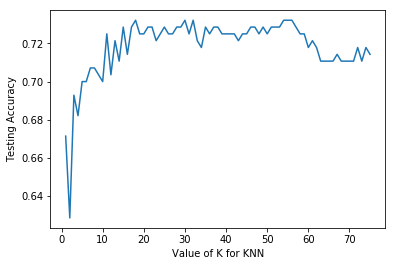

In [148]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

On voit que la précision augmente difficilement au-dessus de 72-74%. Et qu'augmenter N n'est plus utile au delà de 25-05. La précision à ~70% n'est pas si décevante que ça: je pense que je ne ferais pas nécesserairement mieux. Les disciplines sont assez difficiles à distinguer sur la base des données dont nous disposons. La vitesse de déplacement à la course, en ski de fond ou à vélo de montagne ne sont pas si différentes que ça, en moyenne, dans le genre de terrain où je circule. Pour _benchmarker_, je devrais faire l'exercice de classifier moi-même.

# Visualisation

Et si j'essayais d'illustrer mes data sets? Comme on a 8 _features_ mais seulement 2 dimensions, on ne peut pas tout illustrer. Pour trouver quel choix de 2 _features_ donne le _scatter_ le plus intéressant, je pourrais tous les regarder deux à deux.

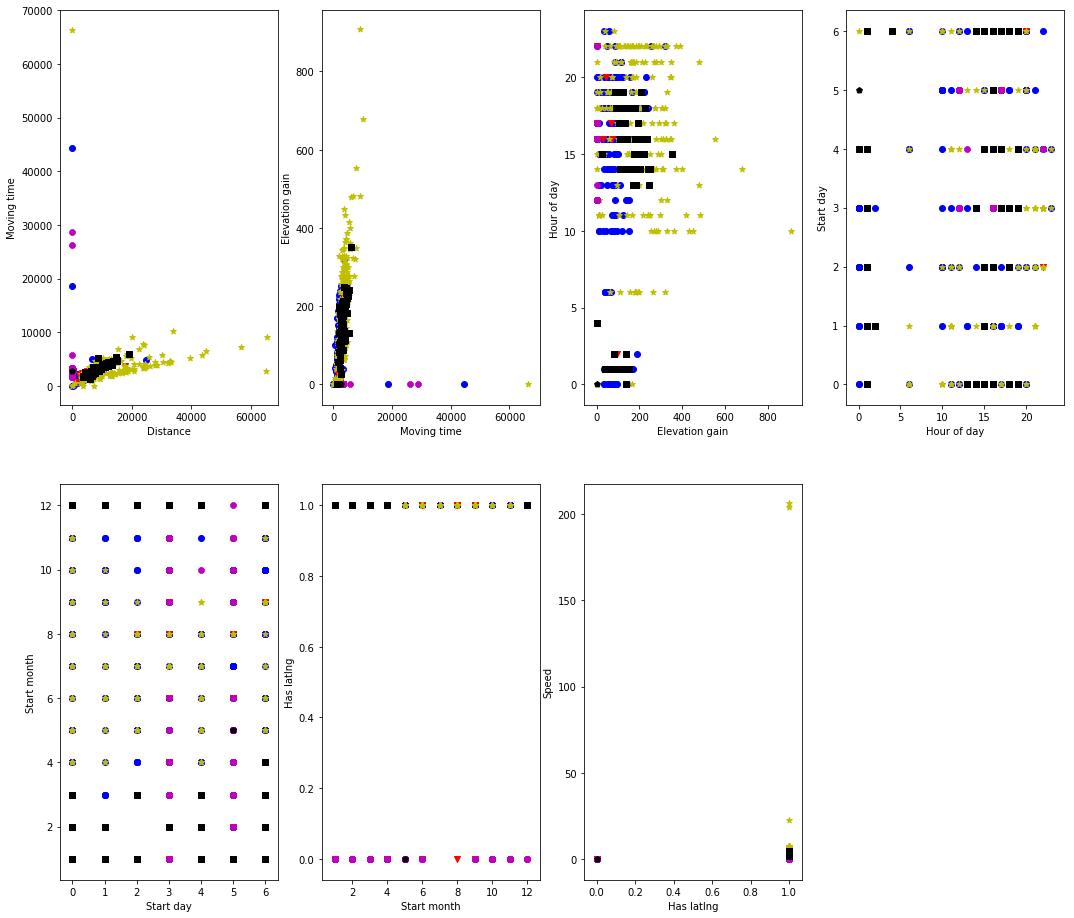

In [149]:
fig = plt.figure(figsize=(18, 16))
colors = { 'Run': 'b', 'Crossfit': 'r', 'Ride': 'y', 'Snowshoe': 'c', 'Spinning': 'm', 'BackcountrySki': 'k', 'VirtualRide': 'k' }
markers = { 'Run': 'o', 'Crossfit': 'v', 'Ride': '*', 'Snowshoe': '<', 'Spinning': '8', 'BackcountrySki': 's', 'VirtualRide': 'p' }
c = np.asarray(map(lambda a: colors[a['type']], activities))
for activity_type in activity_types:
    activities_for_this_type = [activity for activity in activities if activity['type'] == activity_type]
    activity_features = np.asarray(map(lambda a: activity_array_content(a), activities_for_this_type))
    for i in list(range(0,7)):
        ax = plt.subplot(2, 4, i+1)
        ax.scatter(activity_features[:,i], activity_features[:,(i+1)%8], c=colors[activity_type], marker=markers[activity_type])
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel(feature_names[(i+1)%8])

Intuitivement, ce sont la distance, le temps et le gain d'élévation qui sont les données les plus intéressantes. Je pourrais tenter un scatter en 3D avec ces 3 variables.

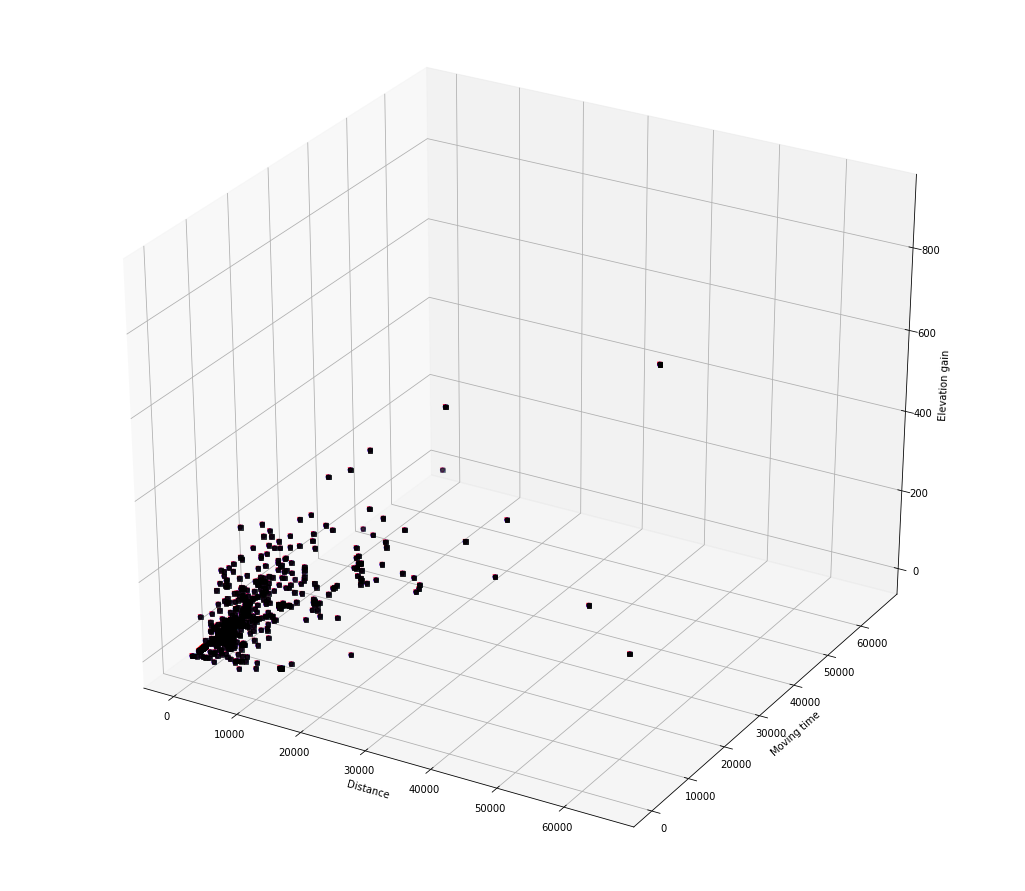

In [150]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Distance')
ax.set_ylabel('Moving time')
ax.set_zlabel('Elevation gain')
for activity_type in activity_types:
    activities_for_this_type = [activity for activity in activities if activity['type'] == activity_type]
    activity_features = np.asarray(map(lambda a: activity_array_content(a), activities_for_this_type))
    ax.scatter(X[:,0], X[:,1], X[:,2], c=colors[activity_type], marker=markers[activity_type])

## Évaluation du modèle

D'abord, on veut évaluer la précision du modèle, soit le pourcentage de bonnes prédictions, en repartant de notre modèle KNN optimal (celui à N=20).

In [151]:
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

0.725


La matrice de confusion nous permet d'identifier là où le modèle fait le plus d'erreurs.

In [153]:
labels = np.array(list(activity_types))
y_pred_all = knn.predict(X)
confusion = metrics.confusion_matrix(y, y_pred_all, labels=labels)
print(confusion)

[[246   0  21   0  20   4   0]
 [ 12   0   1   0   5   0   0]
 [ 46   0 158   0   5  10   0]
 [  1   0   0   0   0   0   0]
 [  2   0   0   0 105   0   0]
 [ 25   0  28   0   0   9   0]
 [  0   0   0   0   1   0   0]]


Les éléments sur la diagonale de la matrice sont de bonnes classifications. Les autres cellules représentent des erreurs de classification. Si on reprend la matrice et qu'on veut transformer ça en affirmations sur les erreurs que font le modèle ça donne...

In [155]:
for x, real_activity_type in enumerate(activity_types):
    act_count = sum(confusion[x])
    print "Lorsque l'activité était " + str(real_activity_type) + "(soit " + str(act_count) + " fois)..."
    for y, pred_activity_type in enumerate(activity_types):
        if x == y:
            print "Il y a eu " + str(confusion[x,y]) + " bonne(s) classification(s) (soit " + str(confusion[x,y]/float(act_count)) + ")"
        elif confusion[x,y] != 0:
            print "Il y a eu " + str(confusion[x,y]) + " erreur(s) portant sur " + pred_activity_type
            

Lorsque l'activité était Run(soit 291 fois)...
Il y a eu 246 bonne(s) classification(s) (soit 0.845360824742)
Il y a eu 21 erreur(s) portant sur Ride
Il y a eu 20 erreur(s) portant sur Spinning
Il y a eu 4 erreur(s) portant sur BackcountrySki
Lorsque l'activité était Crossfit(soit 18 fois)...
Il y a eu 12 erreur(s) portant sur Run
Il y a eu 0 bonne(s) classification(s) (soit 0.0)
Il y a eu 1 erreur(s) portant sur Ride
Il y a eu 5 erreur(s) portant sur Spinning
Lorsque l'activité était Ride(soit 219 fois)...
Il y a eu 46 erreur(s) portant sur Run
Il y a eu 158 bonne(s) classification(s) (soit 0.721461187215)
Il y a eu 5 erreur(s) portant sur Spinning
Il y a eu 10 erreur(s) portant sur BackcountrySki
Lorsque l'activité était Snowshoe(soit 1 fois)...
Il y a eu 1 erreur(s) portant sur Run
Il y a eu 0 bonne(s) classification(s) (soit 0.0)
Lorsque l'activité était Spinning(soit 107 fois)...
Il y a eu 2 erreur(s) portant sur Run
Il y a eu 105 bonne(s) classification(s) (soit 0.981308411215)
L